# Assignment Submission - Sarvam Research Fellowship 

I plan to obtain results for these Pre-trained Fast-text vectors(common crawl) using the Supervised Procrustes method

How to run the code:

1. Clone the repo
2. Download fasttext embeddings(.bin - common crawl) from https://fasttext.cc/docs/en/crawl-vectors.html store it in a folder
3. install the necessary libraries

Declaration: I used GenAI(ChatGPT, Grok) to assist and verify my solution

In [23]:
# Import libraries for embedding loading (fasttext), numerical operations (numpy), progress tracking (tqdm), and efficient search (faiss) - didnt have enough time to solve the optional part due to a MLHC deadline
import fasttext
import numpy as np
from tqdm import tqdm
import faiss
import matplotlib.pyplot as plt

In [3]:
# Set random seeds for NumPy and Python to ensure reproducible results
np.random.seed(42)

In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Data Preparation



### 1.1 Pre-trained Fast-text vectors and limit vocab to top 100K most frequent words


In [6]:
def load_embeddings(file_path, max_words=100000):
    model = fasttext.load_model(file_path)
    words = model.get_words()[:max_words] 
    embeddings = {}
    
    for word in words:
        vector = model.get_word_vector(word)
        vector = vector / np.linalg.norm(vector) 
        embeddings[word] = vector
    
    return embeddings

In [7]:
en_embeddings = load_embeddings('./Fasttext_Embeddings/cc.en.300.bin')
hi_embeddings = load_embeddings('./Fasttext_Embeddings/cc.hi.300.bin')
print(f"Loaded {len(en_embeddings)} English and {len(hi_embeddings)} Hindi embeddings.")

Loaded 100000 English and 100000 Hindi embeddings.


###  1.3 Extract a list of word translation pairs from the MUSE dataset 

In [8]:
def load_MUSE_dictionary(file_path, src_emb, tgt_emb):
    pairs = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            src_word, tgt_word = line.strip().split()
            if src_word in src_emb and tgt_word in tgt_emb:
                pairs.append((src_word, tgt_word))
    return pairs

In [9]:
train_pairs = load_MUSE_dictionary('./MUSE/en-hi.train.txt', en_embeddings, hi_embeddings)
test_pairs = load_MUSE_dictionary('./MUSE/en-hi.test.txt', en_embeddings, hi_embeddings)
print(f"Training pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

Training pairs: 8130, Test pairs: 1600



## 2. Embedding Alignment


### 2.1 Implementing the Procrustes Alignment Method and ensure that the mapping is orthogonal

In [ ]:
# Define Procrustes alignment to compute orthogonal mapping W using SVD on training pairs
# Verify orthogonality of W and return the mapping matrix

def procrustes_alignment(train_pairs, src_emb, tgt_emb):
    # Build matrices X (source) and Y (target)
    X = np.array([src_emb[src_word] for src_word, _ in train_pairs]).T  # Shape: (300, n_pairs)
    Y = np.array([tgt_emb[tgt_word] for _, tgt_word in train_pairs]).T  # Shape: (300, n_pairs)
    
    # Compute the mapping
    M = Y @ X.T  # Shape: (300, 300)
    U, _, Vh = np.linalg.svd(M)
    W = U @ Vh  # Orthogonal matrix: (300, 300)
    
    # Verify orthogonality (W @ W.T should be close to identity)
    assert np.allclose(W @ W.T, np.eye(300), atol=1e-6), "W is not orthogonal"
    return W

In [11]:
W = procrustes_alignment(train_pairs, en_embeddings, hi_embeddings)


## 3. Evaluation


### 3.1 Perform word translation from English to Hindi using the aligned embeddings

In [12]:
# This is slow - so I used the faiss library to improve the speed
# def translate_word(src_word, W, src_emb, tgt_emb):
#     if src_word not in src_emb:
#         return []
#     src_vec = W @ src_emb[src_word]  # Map to target space
#     similarities = [(tgt_word, np.dot(src_vec, tgt_vec)) 
#                     for tgt_word, tgt_vec in tgt_emb.items()]
#     similarities.sort(key=lambda x: x[1], reverse=True)
#     return [tgt_word for tgt_word, _ in similarities[:5]]
# translations = {src: translate_word(src, W, en_embeddings, hi_embeddings) 
#                 for src, _ in test_pairs}
# print("Sample translations:", translations[:5])

In [ ]:
# Build FAISS index for Hindi embeddings to enable fast translation

def build_index(embeddings):
    dim = 300
    index = faiss.IndexFlatIP(dim) 
    vectors = np.array(list(embeddings.values())).astype('float32')
    index.add(vectors)
    return index, list(embeddings.keys())

In [ ]:
# Build index for Hindi embeddings
hi_index, hi_words = build_index(hi_embeddings)

# Define function to translate source word to target language using FAISS for top-5 nearest neighbors
# Returns list of 5 predicted target words

def translate_word_faiss(src_word, W, src_emb, index, tgt_words):
    if src_word not in src_emb:
        return []
    src_vec = (W @ src_emb[src_word]).reshape(1, -1).astype('float32')
    distances, indices = index.search(src_vec, 5)
    return [tgt_words[i] for i in indices[0]]

In [ ]:
# Translate English test words to Hindi using the aligned embeddings and FAISS
# Store results in a dictionary mapping source words to top-5 predictions
translations = {src: translate_word_faiss(src, W, en_embeddings, hi_index, hi_words) for src, _ in test_pairs}

### 3.2 Evaluate translation accuracy using the MUSE test dictionary  and report Precision@1 and Precision5 metrics for the word transaltion task

In [ ]:
# function to compute Precision@1 and Precision@5 for translation accuracy
# Returns percentage metrics based on test pairs and predictions

def evaluate_translation(test_pairs, translations):
    p1, p5 = 0, 0
    for src, correct_tgts in test_pairs:
        if src not in translations:
            continue
        predicted = translations[src]
        correct_tgts = set(correct_tgts.split()) if isinstance(correct_tgts, str) else {correct_tgts}
        p1 += 1 if predicted[0] in correct_tgts else 0
        p5 += 1 if any(tgt in correct_tgts for tgt in predicted) else 0
    total = len([src for src, _ in test_pairs if src in translations])
    return p1 / total * 100, p5 / total * 100

In [17]:
# Compute metrics
p1, p5 = evaluate_translation(test_pairs, translations)
print(f"Precision@1: {p1:.2f}%, Precision@5: {p5:.2f}%")

Precision@1: 28.50%, Precision@5: 53.12%


### 3.3 Compare and Analyse cosine similarites between word pairs to assess cross-lingual semantic similarity 

In [ ]:
# function to compute cosine similarity between mapped source and target word vectors
# Returns similarity score or None if words are missing

def compute_similarity(src_word, tgt_word, W, src_emb, tgt_emb):
    if src_word not in src_emb or tgt_word not in tgt_emb:
        return None
    mapped_vec = W @ src_emb[src_word]
    return np.dot(mapped_vec, tgt_emb[tgt_word])

In [22]:
# Compute average cosine similarities for true test pairs and random pairs
# Print results to assess cross-lingual semantic similarity

# True pairs
true_sims = [compute_similarity(src, tgt, W, en_embeddings, hi_embeddings) for src, tgt in test_pairs if compute_similarity(src, tgt, W, en_embeddings, hi_embeddings) is not None]
true_avg = np.mean(true_sims)

# Random pairs
np.random.shuffle(test_pairs)
random_pairs = [(test_pairs[i][0], test_pairs[i+1][1]) for i in range(len(test_pairs)-1)]
random_sims = [compute_similarity(src, tgt, W, en_embeddings, hi_embeddings) for src, tgt in random_pairs if compute_similarity(src, tgt, W, en_embeddings, hi_embeddings) is not None]
random_avg = np.mean(random_sims)

print(f"Avg similarity (true pairs): {true_avg:.4f}, Avg similarity (random pairs): {random_avg:.4f}")

Avg similarity (true pairs): 0.4135, Avg similarity (random pairs): 0.0860


### 3.4 Conduct an ablation study to assess the impact of bilingual lexicon size on alignment quality. Experiment with different training dictionary sizes (e.g., 5k, 10k, 20k word pairs).

In [20]:
# Perform ablation study by training with different lexicon sizes and evaluating performance
# Store Precision@1 and Precision@5 results for each size
sizes = [1000, 2000, 5000]
results = {}

for size in tqdm(sizes):
    sampled_pairs = np.random.choice(len(train_pairs), size, replace=False)
    sampled_train = [train_pairs[i] for i in sampled_pairs]
    W_sampled = procrustes_alignment(sampled_train, en_embeddings, hi_embeddings)
    sampled_translations = {src: translate_word_faiss(src, W_sampled, en_embeddings, hi_index, hi_words) for src, _ in test_pairs}
    p1, p5 = evaluate_translation(test_pairs, sampled_translations)
    results[size] = (p1, p5)

100%|██████████| 3/3 [01:05<00:00, 21.93s/it]


In [21]:
# Print ablation study results showing impact of training lexicon size on translation accuracy
for size, (p1, p5) in results.items():
    print(f"Training size {size}: P@1 = {p1:.2f}%, P@5 = {p5:.2f}%")

Training size 1000: P@1 = 16.56%, P@5 = 37.75%
Training size 2000: P@1 = 23.38%, P@5 = 44.94%
Training size 5000: P@1 = 27.31%, P@5 = 51.69%


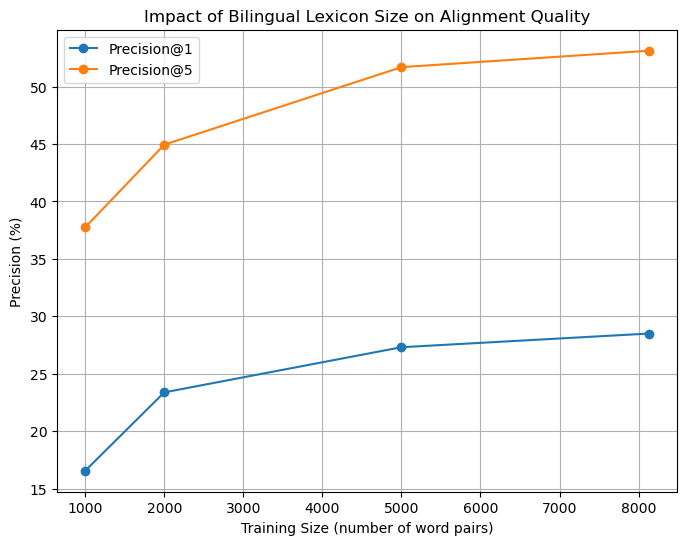

In [ ]:
# Data
training_sizes = [1000, 2000, 5000, 8130]
p_at_1 = [16.56, 23.38, 27.31, 28.50]
p_at_5 = [37.75, 44.94, 51.69, 53.12]

plt.figure(figsize=(8, 6))
plt.plot(training_sizes, p_at_1, marker='o', label='Precision@1')
plt.plot(training_sizes, p_at_5, marker='o', label='Precision@5')
plt.xlabel('Training Size (number of word pairs)')
plt.ylabel('Precision (%)')
plt.title('Impact of Bilingual Lexicon Size on Alignment Quality')
plt.legend()
plt.grid(True)
plt.show()